##### Copyright 2018 The TensorFlow Authors.

In [27]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [28]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [30]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [31]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [32]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [33]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [34]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I found myself very caught up in this movie, at least at the beginning, and any credit I give to this movie, is Lacey Chabert, she was fantastic!! But thats where it ends. I seem to be very good at figuring out who the killer is, and I like it when a movie is able to completely baffel me, but I felt out and out lied to, they whole time they lead you in one direction and then suddenly they decided to go in a completely different direction at the end, they gave no hit to it at all, thats not misleading that very bad writing and planning, someone did not think at all!<br /><br />I felt the movie would have been much better if they had stuck to the plot that the lead you on, they also seemed to not answer anything, why did Jane(maria) burn down the professor's house.<br /><br />Its a great pity as I felt it started out as a relatively good movie."
 b"The person's comment that said that Pat Robertson is evil and his program is evil has nothing to compare what evil and righteous i

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [35]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [36]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [37]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 249, 532, ...,   0,   0,   0],
       [  2,   1, 922, ...,   0,   0,   0],
       [101, 147,   2, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [38]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I found myself very caught up in this movie, at least at the beginning, and any credit I give to this movie, is Lacey Chabert, she was fantastic!! But thats where it ends. I seem to be very good at figuring out who the killer is, and I like it when a movie is able to completely baffel me, but I felt out and out lied to, they whole time they lead you in one direction and then suddenly they decided to go in a completely different direction at the end, they gave no hit to it at all, thats not misleading that very bad writing and planning, someone did not think at all!<br /><br />I felt the movie would have been much better if they had stuck to the plot that the lead you on, they also seemed to not answer anything, why did Jane(maria) burn down the professor's house.<br /><br />Its a great pity as I felt it started out as a relatively good movie."
Round-trip:  i found myself very [UNK] up in this movie at least at the beginning and any [UNK] i give to this movie is [UNK] [UNK]

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [39]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [40]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [41]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.01030382]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [42]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.01030381]


Compile the Keras model to configure the training process:

In [43]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [44]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 42s 90ms/step - loss: 0.6360 - accuracy: 0.5725 - val_loss: 0.4763 - val_accuracy: 0.7964
Epoch 2/10
391/391 [==============================] - 33s 83ms/step - loss: 0.4173 - accuracy: 0.8052 - val_loss: 0.3830 - val_accuracy: 0.8099
Epoch 3/10
391/391 [==============================] - 35s 88ms/step - loss: 0.3526 - accuracy: 0.8460 - val_loss: 0.3635 - val_accuracy: 0.8141
Epoch 4/10
391/391 [==============================] - 35s 88ms/step - loss: 0.3251 - accuracy: 0.8582 - val_loss: 0.3329 - val_accuracy: 0.8479
Epoch 5/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3132 - accuracy: 0.8636 - val_loss: 0.3279 - val_accuracy: 0.8536
Epoch 6/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3045 - accuracy: 0.8695 - val_loss: 0.3360 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3011 - accuracy: 0.8708 - val_loss: 0.3194 - val_accuracy:

In [45]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 50ms/step - loss: 0.3205 - accuracy: 0.8631
Test Loss: 0.3205200135707855
Test Accuracy: 0.8630800247192383


(0.0, 0.6530664265155792)

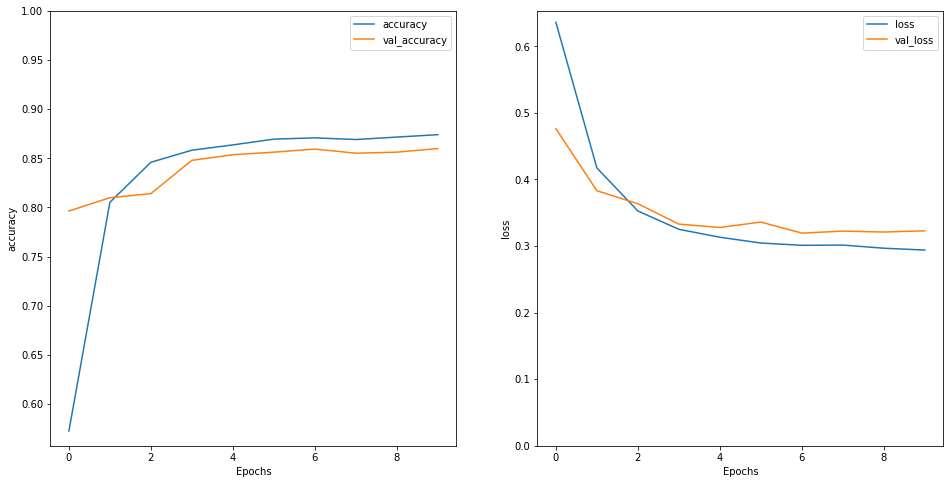

In [46]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [47]:
sample_text1 = ("This is such an awful movie!")
sample_text2 = ("The movie was bad!")
sample_text3 = ("The movie was meh")
sample_text4 = ("The movie was really good!")
sample_text5 = ("The movie was awesome!")


predictions1 = model.predict(np.array([sample_text1]))
predictions2 = model.predict(np.array([sample_text2]))
predictions3 = model.predict(np.array([sample_text3]))
predictions4 = model.predict(np.array([sample_text4]))
predictions5 = model.predict(np.array([sample_text5]))


print("Results from the saved model")
print(predictions1)
print(predictions2)
print(predictions3)
print(predictions4)
print(predictions5)

Results from the saved model
[[-2.0333035]]
[[-1.1821321]]
[[0.0182563]]
[[0.4557745]]
[[0.0182563]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [49]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [50]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [51]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 114s 152ms/step - loss: 0.6529 - accuracy: 0.5566 - val_loss: 0.4517 - val_accuracy: 0.8125
Epoch 2/10
391/391 [==============================] - 55s 141ms/step - loss: 0.3946 - accuracy: 0.8267 - val_loss: 0.3531 - val_accuracy: 0.8391
Epoch 3/10
391/391 [==============================] - 56s 141ms/step - loss: 0.3375 - accuracy: 0.8552 - val_loss: 0.3372 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 56s 143ms/step - loss: 0.3162 - accuracy: 0.8647 - val_loss: 0.3226 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 56s 144ms/step - loss: 0.3096 - accuracy: 0.8672 - val_loss: 0.3227 - val_accuracy: 0.8495
Epoch 6/10
391/391 [==============================] - 56s 142ms/step - loss: 0.3041 - accuracy: 0.8682 - val_loss: 0.3185 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3012 - accuracy: 0.8721 - val_loss: 0.3152 - val_a

In [52]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 28s 73ms/step - loss: 0.3148 - accuracy: 0.8565
Test Loss: 0.3148285150527954
Test Accuracy: 0.8565199971199036


In [59]:
sample_text1 = ("This is such an awful movie!")
sample_text2 = ("The movie was bad!")
sample_text3 = ("The movie was meh")
sample_text4 = ("The movie was really good!")
sample_text5 = ("The movie was awesome!")


predictions1 = model.predict(np.array([sample_text1]))
predictions2 = model.predict(np.array([sample_text2]))
predictions3 = model.predict(np.array([sample_text3]))
predictions4 = model.predict(np.array([sample_text4]))
predictions5 = model.predict(np.array([sample_text5]))


print("Results from the saved model")
print(predictions1)
print(predictions2)
print(predictions3)
print(predictions4)
print(predictions5)

Results from the saved model
[[-0.9865]]
[[-0.33178064]]
[[-0.07745405]]
[[0.2473146]]
[[-0.07745405]]


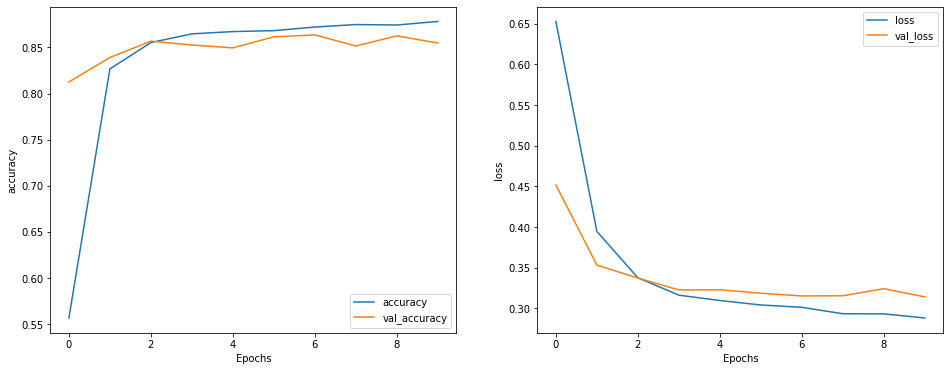

In [54]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
